<a href="https://colab.research.google.com/github/jorobledo/bayesian_statistical_learning_2/blob/main/BLcourse2.3/colab/03_one_dim_SVI_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

In this notebook, we replace the ExactGP inference and log marginal
likelihood optimization by using sparse stochastic variational inference.
This serves as an example of the many methods `gpytorch` offers to make GPs
scale to large data sets.
$\newcommand{\ve}[1]{\mathit{\boldsymbol{#1}}}$
$\newcommand{\ma}[1]{\mathbf{#1}}$
$\newcommand{\pred}[1]{\rm{#1}}$
$\newcommand{\predve}[1]{\mathbf{#1}}$
$\newcommand{\test}[1]{#1_*}$
$\newcommand{\testtest}[1]{#1_{**}}$
$\newcommand{\dd}{{\rm{d}}}$
$\newcommand{\lt}[1]{_{\text{#1}}}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\cov}{cov}$

# Imports, helpers, setup

In [1]:
##%matplotlib notebook
# %matplotlib widget
%matplotlib inline

!pip install -q gpytorch
!wget -q https://raw.githubusercontent.com/jorobledo/bayesian_statistical_learning_2/refs/heads/main/BLcourse2.3/utils.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import math
from collections import defaultdict
from pprint import pprint

import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib import is_interactive
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

from utils import extract_model_params, plot_samples


torch.set_default_dtype(torch.float64)
torch.manual_seed(123)

# Generate toy 1D data

Now we generate 10x more points as in the ExactGP case, still the inference
won't be much slower (exact GPs scale roughly as $N^3$). Note that the data we
use here is still tiny (1000 points is easy even for exact GPs), so the
method's usefulness cannot be fully exploited in our example
-- also we don't even use a GPU yet :).

X_train.shape=torch.Size([682])
y_train.shape=torch.Size([682])
X_pred.shape=torch.Size([200])


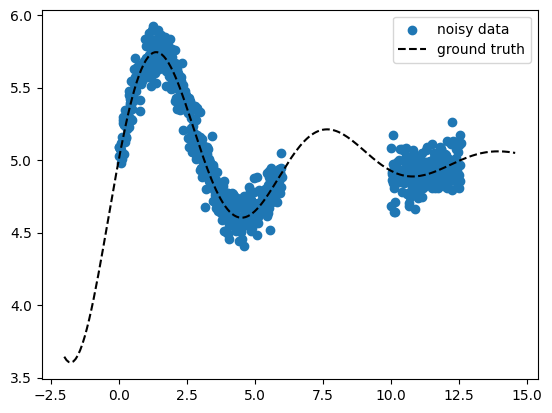

In [4]:
def ground_truth(x, const):
    return torch.sin(x) * torch.exp(-0.2 * x) + const


def generate_data(x, gaps=[[1, 3]], const=None, noise_std=None):
    noise_dist = torch.distributions.Normal(loc=0, scale=noise_std)
    y = ground_truth(x, const=const) + noise_dist.sample(
        sample_shape=(len(x),)
    )
    msk = torch.tensor([True] * len(x))
    if gaps is not None:
        for g in gaps:
            msk = msk & ~((x > g[0]) & (x < g[1]))
    return x[msk], y[msk], y


const = 5.0
noise_std = 0.1
x = torch.linspace(0, 4 * math.pi, 1000)
X_train, y_train, y_gt_train = generate_data(
    x, gaps=[[6, 10]], const=const, noise_std=noise_std
)
X_pred = torch.linspace(
    X_train[0] - 2, X_train[-1] + 2, 200, requires_grad=False
)
y_gt_pred = ground_truth(X_pred, const=const)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_pred.shape=}")

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, marker="o", color="tab:blue", label="noisy data")
ax.plot(X_pred, y_gt_pred, ls="--", color="k", label="ground truth")
ax.legend()

# Define GP model

The model follows [this
example](https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html)
based on [Hensman et al., "Scalable Variational Gaussian Process Classification",
2015](https://proceedings.mlr.press/v38/hensman15.html). The model is
"sparse" since it works with a set of *inducing* points $(\ma Z, \ve u),
\ve u=f(\ma Z)$ which is much smaller than the train data $(\ma X, \ve y)$.
See also [the GPJax
docs](https://docs.jaxgaussianprocesses.com/_examples/uncollapsed_vi) for a
nice introduction.

We have the same hyper parameters as before

* $\ell$ = `model.covar_module.base_kernel.lengthscale`
* $\sigma_n^2$ = `likelihood.noise_covar.noise`
* $s$ = `model.covar_module.outputscale`
* $m(\ve x) = c$ = `model.mean_module.constant`

plus additional ones, introduced by the approximations used:

* the learnable inducing points $\ma Z$ for the variational distribution
  $q_{\ve\psi}(\ve u)$
* learnable parameters of the variational distribution $q_{\ve\psi}(\ve u)=\mathcal N(\ve m_u, \ma S)$: the
  variational mean $\ve m_u$ and covariance $\ma S$ in form a lower triangular
  matrix $\ma L$ such that $\ma S=\ma L\,\ma L^\top$

In [5]:
class ApproxGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, Z):
        # Approximate inducing value posterior q(u), u = f(Z), Z = inducing
        # points (subset of X_train)
        variational_distribution = (
            gpytorch.variational.CholeskyVariationalDistribution(Z.size(0))
        )
        # Compute q(f(X)) from q(u)
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            Z,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

n_train = len(X_train)
# Start values for inducing points Z, use 10% random sub-sample of X_train.
ind_points_fraction = 0.1
ind_idxs = torch.randperm(n_train)[: int(n_train * ind_points_fraction)]
model = ApproxGPModel(Z=X_train[ind_idxs])

In [6]:
# Inspect the model
print(model)

ApproxGPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


In [7]:
# Inspect the likelihood. In contrast to ExactGP, the likelihood is not part of
# the GP model instance.
print(likelihood)

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)


In [8]:
# Default start hyper params
print("model params:")
pprint(extract_model_params(model))
print("likelihood params:")
pprint(extract_model_params(likelihood))

model params:
{'covar_module.base_kernel.lengthscale': tensor([[0.6931]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(0.6931, grad_fn=<SoftplusBackward0>),
 'mean_module.constant': Parameter containing:
tensor(0., requires_grad=True),
 'variational_strategy._variational_distribution.chol_variational_covar': Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], requires_grad=True),
 'variational_strategy._variational_distribution.variational_mean': Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [9]:
# Set new start hyper params (scalars only)
model.mean_module.constant = 3.0
model.covar_module.base_kernel.lengthscale = 1.0
model.covar_module.outputscale = 1.0
likelihood.noise_covar.noise = 0.3

# Fit GP to data: optimize hyper params

Now we optimize the GP hyper parameters by doing a GP-specific variational
inference (VI), where we don't maximize the log marginal likelihood (ExactGP
case), but an ELBO ("evidence lower bound") objective -- a lower bound on the
marginal likelihood (the "evidence"). In variational inference, an ELBO objective
shows up when minimizing the KL divergence between
an approximate and the true posterior

$$
    p(w|y) = \frac{p(y|w)\,p(w)}{\int p(y|w)\,p(w)\,\dd w}
           = \frac{p(y|w)\,p(w)}{p(y)}
$$

$$
  \ve\zeta^* = \text{arg}\min_{\ve\zeta} D\lt{KL}(q_{\ve\zeta}(w)\,\Vert\, p(w|y))
$$

to obtain the optimal variational parameters $\ve\zeta^*$ to approximate
$p(w|y)$ with $q_{\ve\zeta^*}(w)$.

In our case the two distributions are the approximate

$$q_{\ve\zeta}(\mathbf f)=\int p(\mathbf f|\ve u)\,q_{\ve\psi}(\ve u)\,\dd\ve u\quad(\text{"variational strategy"})$$

and the true $p(\mathbf f|\mathcal D)$ posterior over function values. We
optimize with respect to

$$\ve\zeta = [\ell, \sigma_n^2, s, c, \ve\psi] $$

with

$$\ve\psi = [\ve m_u, \ma Z, \ma L]$$

the parameters of the variational distribution $q_{\ve\psi}(\ve u)$.

In addition, we perform a stochastic
optimization by using a deep learning type mini-batch loop, hence
"stochastic" variational inference (SVI). The latter speeds up the
optimization since we only look at a fraction of data per optimizer step to
calculate an approximate loss gradient (`loss.backward()`).

In [10]:
# Train mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(
    [dict(params=model.parameters()), dict(params=likelihood.parameters())],
    lr=0.1,
)
loss_func = gpytorch.mlls.VariationalELBO(
    likelihood, model, num_data=X_train.shape[0]
)

train_dl = DataLoader(
    TensorDataset(X_train, y_train), batch_size=128, shuffle=True
)

n_iter = 200
history = defaultdict(list)
for i_iter in range(n_iter):
    for i_batch, (X_batch, y_batch) in enumerate(train_dl):
        batch_history = defaultdict(list)
        optimizer.zero_grad()
        loss = -loss_func(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        param_dct = dict()
        param_dct.update(extract_model_params(model, try_item=True))
        param_dct.update(extract_model_params(likelihood, try_item=True))
        for p_name, p_val in param_dct.items():
            if isinstance(p_val, float):
                batch_history[p_name].append(p_val)
        batch_history["loss"].append(loss.item())
    for p_name, p_lst in batch_history.items():
        history[p_name].append(np.mean(p_lst))
    if (i_iter + 1) % 10 == 0:
        print(f"iter {i_iter + 1}/{n_iter}, {loss=:.3f}")

iter 10/200, loss=0.533
iter 20/200, loss=-0.390
iter 30/200, loss=-0.709
iter 40/200, loss=-0.835
iter 50/200, loss=-0.898
iter 60/200, loss=-0.917
iter 70/200, loss=-0.857
iter 80/200, loss=-0.907
iter 90/200, loss=-0.876
iter 100/200, loss=-0.871
iter 110/200, loss=-0.811
iter 120/200, loss=-0.972
iter 130/200, loss=-0.885
iter 140/200, loss=-0.887
iter 150/200, loss=-0.813
iter 160/200, loss=-0.873
iter 170/200, loss=-0.728
iter 180/200, loss=-0.949
iter 190/200, loss=-0.961
iter 200/200, loss=-0.903


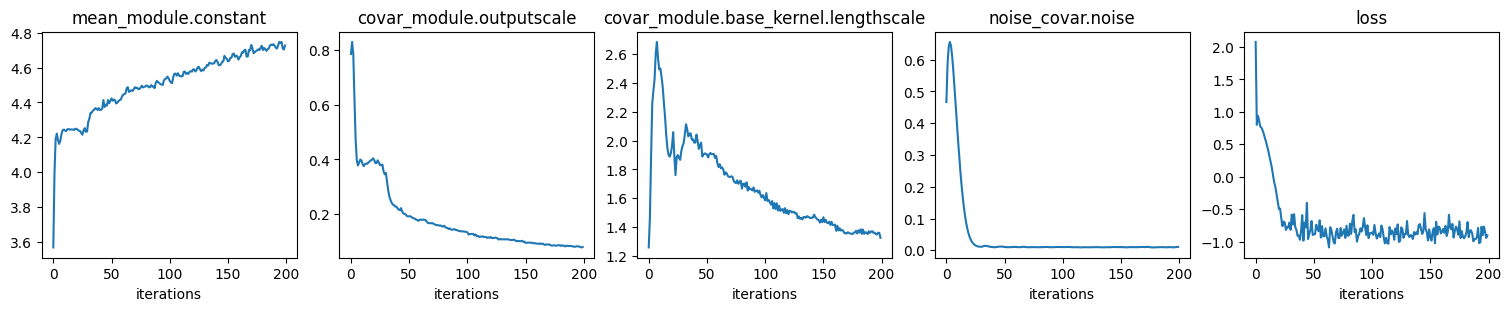

In [11]:
# Plot scalar hyper params and loss (ELBO) convergence
ncols = len(history)
fig, axs = plt.subplots(
    ncols=ncols, nrows=1, figsize=(ncols * 3, 3), layout="compressed"
)
with torch.no_grad():
    for ax, (p_name, p_lst) in zip(axs, history.items()):
        ax.plot(p_lst)
        ax.set_title(p_name)
        ax.set_xlabel("iterations")

In [12]:
# Values of optimized hyper params
print("model params:")
pprint(extract_model_params(model))
print("likelihood params:")
pprint(extract_model_params(likelihood))

model params:
{'covar_module.base_kernel.lengthscale': tensor([[1.3243]], grad_fn=<SoftplusBackward0>),
 'covar_module.outputscale': tensor(0.0800, grad_fn=<SoftplusBackward0>),
 'mean_module.constant': Parameter containing:
tensor(4.7260, requires_grad=True),
 'variational_strategy._variational_distribution.chol_variational_covar': Parameter containing:
tensor([[ 2.8488e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.1749e-04,  4.7867e-02,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.3617e-04, -5.9018e-02,  9.9083e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-7.7055e-05, -3.6877e-03, -7.7754e-03,  ...,  1.0002e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3939e-04, -6.0350e-04, -3.3939e-03,  ...,  3.0690e-04,
          1.0023e+00,  0.0000e+00],
        [-1.4790e-03,  3.0466e-03,  3.8520e-03,  ...,  3.4510e-04,
          1.0821e-04,  9.9964e-01]], requires_gr

# Run prediction

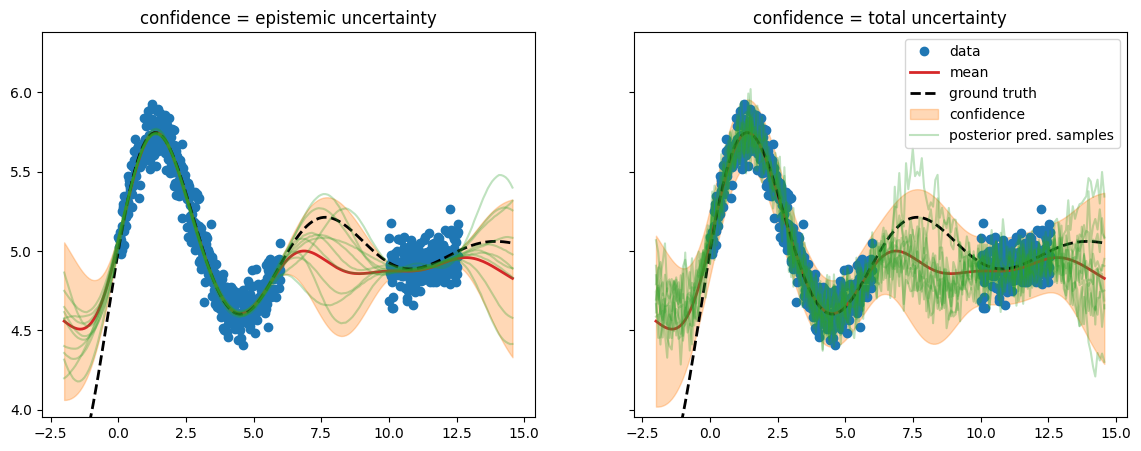

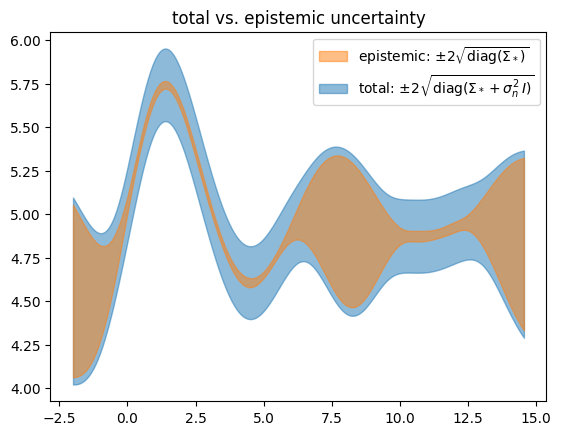

In [13]:
# Evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad():
    M = 10
    post_pred_f = model(X_pred)
    post_pred_y = likelihood(model(X_pred))

    fig, axs = plt.subplots(ncols=2, figsize=(14, 5), sharex=True, sharey=True)
    fig_sigmas, ax_sigmas = plt.subplots()
    for ii, (ax, post_pred, name, title) in enumerate(
        zip(
            axs,
            [post_pred_f, post_pred_y],
            ["f", "y"],
            ["epistemic uncertainty", "total uncertainty"],
        )
    ):
        yf_mean = post_pred.mean
        yf_samples = post_pred.sample(sample_shape=torch.Size((M,)))

        yf_std = post_pred.stddev
        lower = yf_mean - 2 * yf_std
        upper = yf_mean + 2 * yf_std
        ax.plot(
            X_train.numpy(),
            y_train.numpy(),
            "o",
            label="data",
            color="tab:blue",
        )
        ax.plot(
            X_pred.numpy(),
            yf_mean.numpy(),
            label="mean",
            color="tab:red",
            lw=2,
        )
        ax.plot(
            X_pred.numpy(),
            y_gt_pred.numpy(),
            label="ground truth",
            color="k",
            lw=2,
            ls="--",
        )
        ax.fill_between(
            X_pred.numpy(),
            lower.numpy(),
            upper.numpy(),
            label="confidence",
            color="tab:orange",
            alpha=0.3,
        )
        ax.set_title(f"confidence = {title}")
        if name == "f":
            sigma_label = r"epistemic: $\pm 2\sqrt{\mathrm{diag}(\Sigma_*)}$"
            zorder = 1
        else:
            sigma_label = (
                r"total: $\pm 2\sqrt{\mathrm{diag}(\Sigma_* + \sigma_n^2\,I)}$"
            )
            zorder = 0
        ax_sigmas.fill_between(
            X_pred.numpy(),
            lower.numpy(),
            upper.numpy(),
            label=sigma_label,
            color="tab:orange" if name == "f" else "tab:blue",
            alpha=0.5,
            zorder=zorder,
        )
        y_min = y_train.min()
        y_max = y_train.max()
        y_span = y_max - y_min
        ax.set_ylim([y_min - 0.3 * y_span, y_max + 0.3 * y_span])
        plot_samples(ax, X_pred, yf_samples, label="posterior pred. samples")
        if ii == 1:
            ax.legend()
    ax_sigmas.set_title("total vs. epistemic uncertainty")
    ax_sigmas.legend()

# Let's check the learned noise

In [14]:
# Target noise to learn
print("data noise:", noise_std)

# The two below must be the same
print(
    "learned noise:",
    (post_pred_y.stddev**2 - post_pred_f.stddev**2).mean().sqrt().item(),
)
print(
    "learned noise:",
    np.sqrt(
        extract_model_params(likelihood, try_item=True)["noise_covar.noise"]
    ),
)

data noise: 0.1
learned noise: 0.10390090987348762
learned noise: 0.10390090987348763


In [15]:
# When running as script
if not is_interactive():
    plt.show()